#Import packages 

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Activation, Dense, Dropout, Conv1D, Flatten, MaxPooling1D , Conv2D, MaxPooling2D

from keras.models import Sequential

import librosa

import librosa.display

import numpy as np

import pandas as pd

import random

import matplotlib.pyplot as plt

import csv

%matplotlib inline

import os

import warnings
warnings.filterwarnings('ignore')


#Load Data Method 1 

In [2]:
!curl -O http://storage.googleapis.com/eu_audioset/youtube_corpus/v1/features/features.tar.gz
!curl -O http://storage.googleapis.com/eu_audioset/youtube_corpus/v1/csv/class_labels_indices.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2468M  100 2468M    0     0  12.2M      0  0:03:21  0:03:21 --:--:-- 12.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14675  100 14675    0     0   8085      0  0:00:01  0:00:01 --:--:--  8080


#Extracting tfRecods files

In [3]:
!tar xvfz features.tar.gz | wc -l

12232


#Parsing the csv file with the names of the labels

In [6]:
with open('class_labels_indices.csv', encoding='utf-8') as class_map_csv:
  class_names = [display_name for (class_index, mid, display_name) in csv.reader(class_map_csv)]
  class_names = class_names[1:]  # Skips the CSV header

class_names = np.array(class_names)

#Reading tfrecord data


In [7]:
tfrecord_files = os.listdir('audioset_v1_embeddings/bal_train/')
raw_dataset = tf.data.TFRecordDataset([os.path.join('audioset_v1_embeddings/bal_train/', f) for f in tfrecord_files])

for raw_record in raw_dataset.take(1):
  tf_seq_example = tf.train.SequenceExample()
  tf_seq_example.ParseFromString(raw_record.numpy())
  print(tf_seq_example)


context {
  feature {
    key: "end_time_seconds"
    value {
      float_list {
        value: 10.0
      }
    }
  }
  feature {
    key: "labels"
    value {
      int64_list {
        value: 185
        value: 187
      }
    }
  }
  feature {
    key: "start_time_seconds"
    value {
      float_list {
        value: 0.0
      }
    }
  }
  feature {
    key: "video_id"
    value {
      bytes_list {
        value: "vnSD0d7yV8s"
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "audio_embedding"
    value {
      feature {
        bytes_list {
          value: "\227L\206i\244V\272q\261\356\232\215{mz.r*\306\216OD\267!6\321E\020\240j{\273\343\266C\247#\225Gv\350c\364\272TU\202e\n@\322\377k\n\256 \234\260kE\377j\237\204\000gDWk\344\236\222\256\231G\263\275o\220\271vN\366\214\302h\206\321\000\226\253\000g8\002&\344\031zZ\277\3772\305\016.H\270c\00002\377\242}0\025\377gI\213{\343\272\030\000\202\225"
        }
      }
      feature {
        bytes_list {
          value: "

#Taking all the data
 

In [8]:
# Create a description of the features.
context = {
    'end_time_seconds': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
    'video_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'start_time_seconds': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
    'labels': tf.io.VarLenFeature(tf.int64),    
}

sequence = {
    'audio_embedding': tf.io.FixedLenSequenceFeature([], tf.string, default_value=None ,allow_missing=True)
}

def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_sequence_example(example_proto, context_features=context, sequence_features=sequence)


In [9]:
parsed_dataset = raw_dataset.map(_parse_function)

In [10]:
#Evaluation  

evaluation  = os.listdir('audioset_v1_embeddings/eval/')
eval_dataset = tf.data.TFRecordDataset([os.path.join('audioset_v1_embeddings/eval/', f) for f in evaluation])

parsed_eval_dataset = eval_dataset.map(_parse_function)


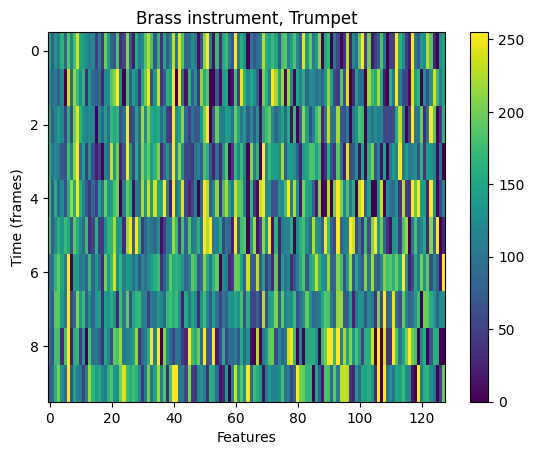

In [11]:
#Displays Image
import matplotlib.pyplot as plt

def visualize_embedding(embedding, label):
    plt.imshow(embedding, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(label)
    plt.xlabel('Features')
    plt.ylabel('Time (frames)')
    plt.show()

# Get a single example from the preprocessed dataset
for example in parsed_dataset.take(1):
    context, sequence = example
    raw_embedding = sequence['audio_embedding'].numpy()
    embedding1 = np.stack([np.frombuffer(em, dtype=np.uint8) for em in raw_embedding])
    
    labels = context['labels'].values.numpy()
    label_names = ', '.join(class_names[labels])
  
visualize_embedding(embedding1, label_names)


In [12]:
total_images = 0

for example in parsed_dataset:
    total_images += 1

print("Total number of images in the dataset:", total_images)


Total number of images in the dataset: 22160


In [14]:
  import numpy as np
  import matplotlib.pyplot as plt

  # Function to store images as arrays in a list
  def store_embedding_to_list(embedding, label):
      fig, ax = plt.subplots()
      ax.imshow(embedding, cmap='viridis', aspect='auto')
      ax.set_xticks([])  # Remove x-axis ticks
      ax.set_yticks([])  # Remove y-axis ticks
      ax.axis('off')  # Remove axis frame

      fig.canvas.draw()
      image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
      image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
     
      plt.close(fig)

      return image_array

  # Example usage
  image_training = []
  image_labels = []
  num_images = 0

  # Store image as an array in a list
  for example in parsed_dataset:
      if num_images >= 500:
          break

      context, sequence = example
      raw_embedding = sequence['audio_embedding'].numpy()
      embedding1 = np.stack([np.frombuffer(em, dtype=np.uint8) for em in raw_embedding])

      labels = context['labels'].values.numpy()
      label_names = ', '.join(class_names[labels])

      image_array = store_embedding_to_list(embedding1, label_names)
      image_training.append(image_array)
      image_labels.append(labels)

      num_images += 1

In [15]:
print("Original image shape:", image_array.shape)


Original image shape: (480, 640, 3)


In [19]:
#To reduce image size thus reduceing GPU resources
from PIL import Image

def downscale_image(image, new_width, new_height):
    # Resizing the image using the provided dimensions
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
    return resized_image

new_width = 340
new_height = 220


In [ ]:
 #See the number of class I got
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to store images as arrays in a list
def store_embedding_to_list(embedding, label):
    fig, ax = plt.subplots()
    ax.imshow(embedding, cmap='viridis', aspect='auto')
    ax.set_xticks([])  # Removes x-axis ticks
    ax.set_yticks([])  # Removes y-axis ticks
    ax.axis('off')  # Removes axis frame

    fig.canvas.draw()
    image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Resize image using the PIL package
    image_array = Image.fromarray(image_array)
    image_array = downscale_image(image_array, new_width, new_height)
    image_array = np.array(image_array)

    plt.close(fig)

    return image_array

# Example usage
image_training = []
image_labels = []
num_images = 0

# Initialize a dictionary to store the counts for each class
class_counts = defaultdict(int)

# Store image as an array in a list
for example in parsed_dataset:
    if num_images >= 500:
        break

    context, sequence = example
    raw_embedding = sequence['audio_embedding'].numpy()
    embedding1 = np.stack([np.frombuffer(em, dtype=np.uint8) for em in raw_embedding])

    labels = context['labels'].values.numpy()
    label_names = ', '.join(class_names[labels])

    # Update the class_counts dictionary
    for label in labels:
        class_counts[label] += 1

    image_array = store_embedding_to_list(embedding1, label_names)
    image_training.append(image_array)
    image_labels.append(labels)

    num_images += 1

# Print the number of samples per class
for class_index, count in sorted(class_counts.items()):
    print(f"Class {class_index} ({class_names[class_index]}): {count} samples")


Class 0 (Speech): 126 samples
Class 2 (Female speech, woman speaking): 3 samples
Class 3 (Child speech, kid speaking): 6 samples
Class 5 (Narration, monologue): 2 samples
Class 6 (Babbling): 1 samples
Class 10 (Whoop): 2 samples
Class 11 (Yell): 1 samples
Class 12 (Battle cry): 2 samples
Class 13 (Children shouting): 1 samples
Class 16 (Laughter): 1 samples
Class 17 (Baby laughter): 1 samples
Class 20 (Belly laugh): 2 samples
Class 21 (Chuckle, chortle): 1 samples
Class 25 (Wail, moan): 3 samples
Class 26 (Sigh): 1 samples
Class 27 (Singing): 12 samples
Class 28 (Choir): 1 samples
Class 29 (Yodeling): 4 samples
Class 30 (Chant): 2 samples
Class 32 (Male singing): 1 samples
Class 33 (Female singing): 2 samples
Class 34 (Child singing): 5 samples
Class 35 (Synthetic singing): 3 samples
Class 37 (Humming): 1 samples
Class 38 (Groan): 1 samples
Class 39 (Grunt): 2 samples
Class 40 (Whistling): 3 samples
Class 41 (Breathing): 1 samples
Class 42 (Wheeze): 1 samples
Class 43 (Snoring): 3 samp

In [ ]:
print(f"Total samples: {num_images}")


Total samples: 500


In [ ]:
unique_classes = len(class_counts)
print(f"Number of unique classes: {unique_classes}")


Number of unique classes: 409


In [ ]:
val_training = []
val_labels = []
num_images = 0

# Store image as an array in a list
for example in parsed_eval_dataset:
    if num_images >= 500:
        break

    context, sequence = example
    raw_embedding = sequence['audio_embedding'].numpy()
    embedding1 = np.stack([np.frombuffer(em, dtype=np.uint8) for em in raw_embedding])

    labels = context['labels'].values.numpy()
    label_names = ', '.join(class_names[labels])

    image_array = store_embedding_to_list(embedding1, label_names)
    val_training.append(image_array)  
    val_labels.append(labels)         

    num_images += 1


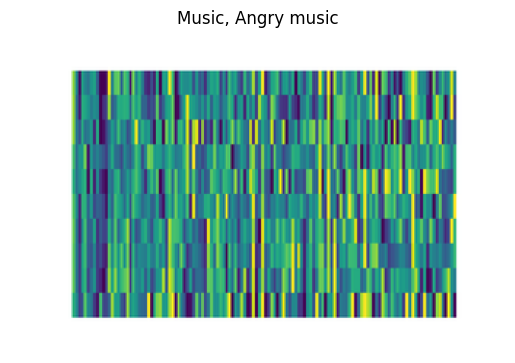

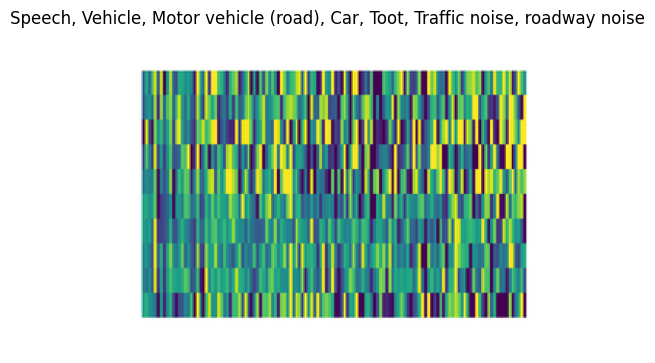

In [ ]:
def display_images(image_training, image_labels, num_images):
    for i in range(num_images):
        plt.figure()
        plt.imshow(image_training[i])
        plt.title(', '.join(class_names[image_labels[i]]))
        plt.axis('off')
        plt.show()


# Example usage
display_images(image_training, image_labels, 2)
 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Convert image_training to a NumPy array and normalize pixel values
image_training_array = np.array(image_training, dtype=np.float32) / 255.0
image_labels_array = np.array(image_labels)

val_image_training = np.array(val_training, dtype=np.float32) / 255.0 
val_image_label_training= np.array(val_labels)

#An iterator for augmented images
image_training_iterator = datagen.flow(image_training_array, image_labels_array, batch_size=32)

#Gets a batch of augmented images
augmented_images, augmented_labels = next(image_training_iterator)


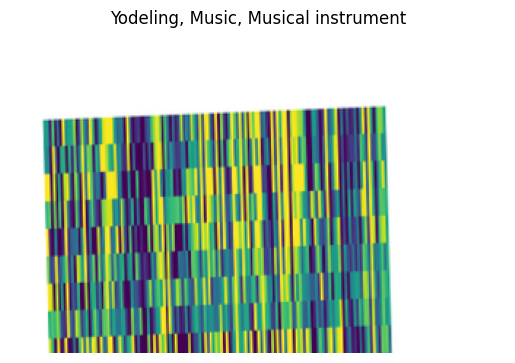

In [ ]:
# Display 1 augmented images
display_images(augmented_images, augmented_labels, 1)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(image_labels_array)
y_val_binarized = mlb.transform(val_image_label_training)


In [ ]:
#Model 1
# Import the required libraries
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(220, 340, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))  # Use sigmoid activation for multi-label classification


In [ ]:
#Model 2
# Import the required libraries
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(220, 340, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.05)) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.15)) 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))  # Use sigmoid activation for multi-label classification


In [ ]:
#Model 3
# Import the required libraries
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.regularizers import l2

# Set regularization strength
reg_strength = 0.001

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(220, 340, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Dropout(0.15))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg_strength)))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))


In [ ]:
print("val_image_training shape:", val_image_training.shape)
print("val_image_training dtype:", val_image_training.dtype)
print("y_val_binarized shape:", y_val_binarized.shape)
print("y_val_binarized dtype:", y_val_binarized.dtype)


val_image_training shape: (500, 220, 340, 3)
val_image_training dtype: float32
y_val_binarized shape: (500, 420)
y_val_binarized dtype: int64


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_training_array, y_train_binarized)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_training, y_val_binarized)).batch(32)


In [ ]:
from tensorflow.keras.optimizers import Adam


# Learning rate
learning_rate = 0.001  

# Instantiate the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compiles the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Prints the model summary
model.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 218, 338, 32)      896       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 109, 169, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 107, 167, 64)      18496     
                                                                 
 dropout_71 (Dropout)        (None, 107, 167, 64)      0         
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 53, 83, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 51, 81, 64)      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

#Model training 
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset,  callbacks=[early_stopping_callback])


Epoch 1/100
16/16 [==============================] - 4s 175ms/step - loss: 0.6559 - accuracy: 0.0000e+00 - val_loss: 0.4760 - val_accuracy: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 2s 139ms/step - loss: 0.3090 - accuracy: 0.0060 - val_loss: 0.1292 - val_accuracy: 0.0000e+00
Epoch 3/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0717 - accuracy: 0.0060 - val_loss: 0.0383 - val_accuracy: 0.3360
Epoch 4/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0368 - accuracy: 0.2060 - val_loss: 0.0324 - val_accuracy: 0.1600
Epoch 5/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0336 - accuracy: 0.1620 - val_loss: 0.0310 - val_accuracy: 0.1600
Epoch 6/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0325 - accuracy: 0.2280 - val_loss: 0.0305 - val_accuracy: 0.1600
Epoch 7/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0319 - accuracy: 0.1920 - val_loss: 0.0301 - val_accu

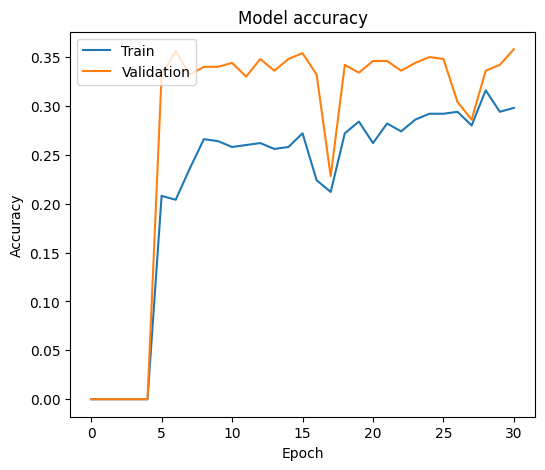

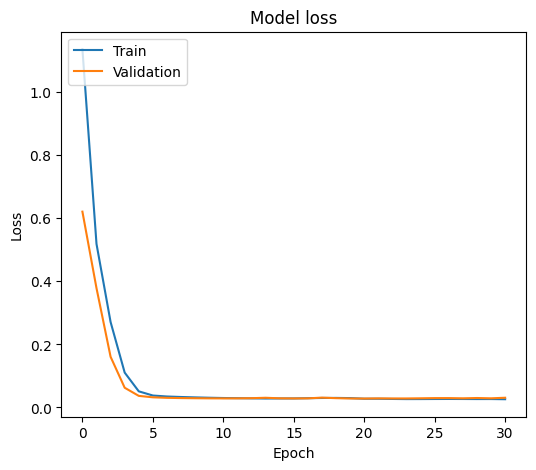

In [ ]:
#Model 1
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


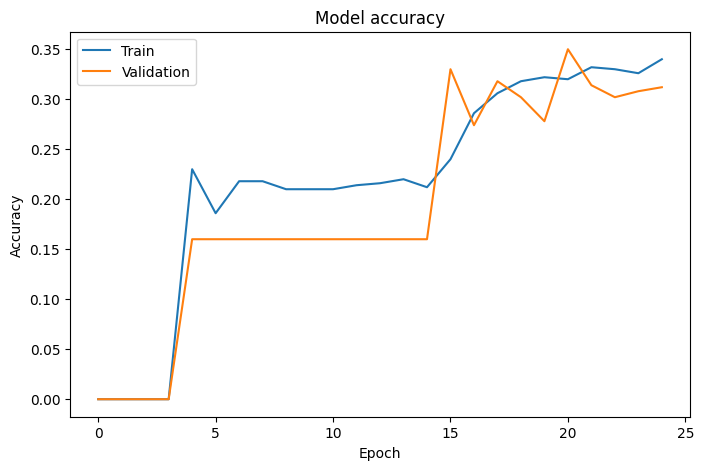

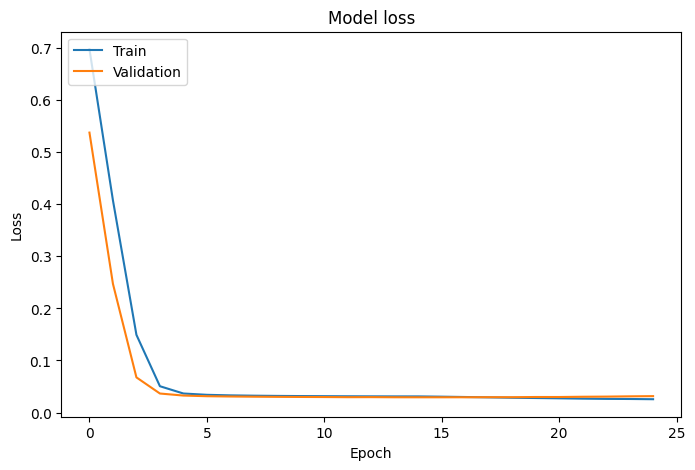

In [ ]:
#Model 2
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.autoscale(enable=True, axis='both', tight=None)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


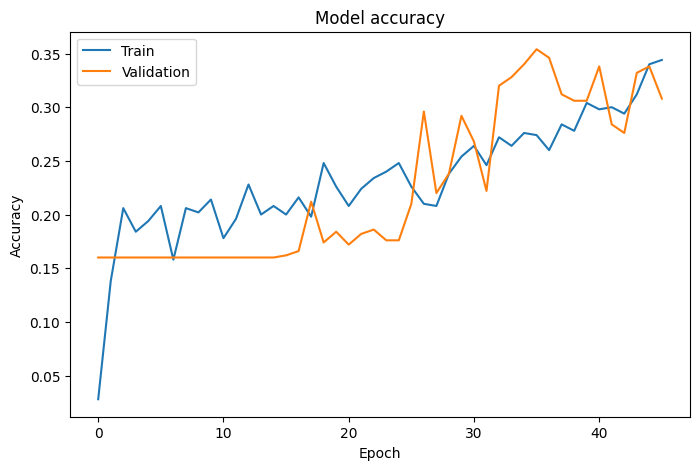

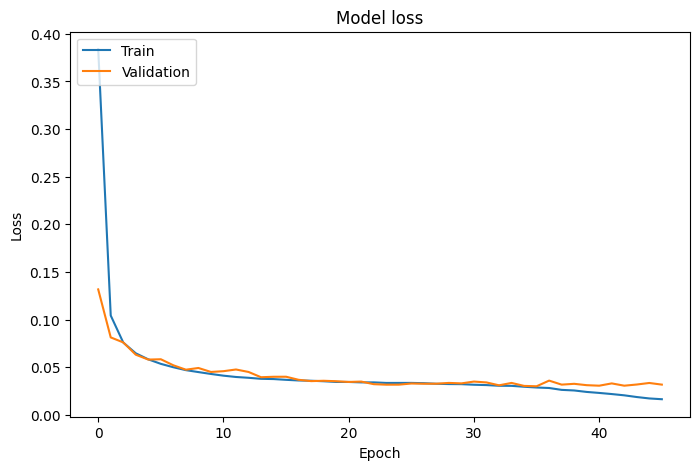

In [ ]:
#Model 3
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.autoscale(enable=True, axis='both', tight=None)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/my_cnn_model_image.h5"
model.save(model_path)
